# Reranker Analysis by Andrew Taylor

# Reranker Analysis (file‑based)
*Updated on 2025‑04‑13*

This notebook loads its **corpus** and **questions** from disk so the evaluation
is fully data‑driven and reproducible.

**Paths**

* `storage/corpus/*.txt` – raw text documents  
* `qa_resources/question.tsv` – tab‑separated file with a `Question` column


In [1]:
# ─── Path setup so `from reranker import Reranker` works ──────────────────────
import sys, os

# Resolve the directory that is one level above the notebook file
# (works whether you run from Jupyter Lab, VS Code, or plain IPython)
try:
    nb_dir = os.path.dirname(os.path.abspath(__file__))  # when executed as .py
except NameError:
    nb_dir = os.getcwd()                                 # when inside Jupyter

parent_dir = os.path.abspath(os.path.join(nb_dir, ".."))  # go one level up
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)                        # make it importable

# Now the normal import succeeds
from modules.retrieval.reranker import Reranker


In [2]:
import os, glob, pandas as pd

# Configure paths
CORPUS_GLOB   = os.path.join("..", "storage", "*.txt.clean")
QUESTION_FILE = os.path.join("..", "qa_resources", "question.tsv")

# ---- Load corpus ----
corpus = []
for path in glob.glob(CORPUS_GLOB):
    try:
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
            if txt:
                corpus.append(txt)
    except Exception as e:
        print(f"[WARN] could not read {path}: {e}")
print(f"[INFO] Loaded {len(corpus)} corpus documents.")

# ---- Load questions ----
questions_df = pd.read_csv(QUESTION_FILE, sep="\t")
questions    = questions_df["Question"].dropna().tolist()
print(f"[INFO] Loaded {len(questions)} questions. Showing first 3:")
for q in questions[:3]:
    print(" •", q)


[WARN] could not read ..\storage\S08_set4_a8.txt.clean: 'utf-8' codec can't decode byte 0xe8 in position 907: invalid continuation byte
[WARN] could not read ..\storage\S09_set3_a2.txt.clean: 'utf-8' codec can't decode byte 0xe9 in position 1871: invalid continuation byte
[WARN] could not read ..\storage\S09_set3_a6.txt.clean: 'utf-8' codec can't decode byte 0xed in position 525: invalid continuation byte
[WARN] could not read ..\storage\S09_set4_a8.txt.clean: 'utf-8' codec can't decode byte 0xe8 in position 907: invalid continuation byte
[INFO] Loaded 146 corpus documents.
[INFO] Loaded 1034 questions. Showing first 3:
 • Was Abraham Lincoln the sixteenth President of the United States?
 • Was Abraham Lincoln the sixteenth President of the United States?
 • Did Lincoln sign the National Banking Act of 1863?


In [3]:

import numpy as np, math
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

rerank_types = ["bow", "tfidf", "cross_encoder", "hybrid", "sequential"]

# ---------- Cell 3 (run all rerankers) ----------
rerank_types = ["bow", "tfidf", "cross_encoder", "hybrid", "sequential"]

def run_all_rerankers(query):
    out = {}
    for rtype in rerank_types:
        rr = Reranker(type=rtype)

        # ✱ REPLACE THIS LINE  ──────────────────────────────────────────────
        # ranked_docs, idx, _ = rr.rerank(query, corpus, seq_k1=5, seq_k2=5)
        # ✱ WITH THIS:  (same length ranking for every strategy)
        ranked_docs, idx, _ = rr.rerank(
            query,
            corpus,
            seq_k1=len(corpus),   # keep all docs
            seq_k2=len(corpus)    # keep all docs
        )
        # ───────────────────────────────────────────────────────────────────

        out[rtype] = idx
    return out


# For brevity analyse first 3 questions
selected_qs = questions[:3]
all_results = {q: run_all_rerankers(q) for q in selected_qs}
print("Collected rankings for", len(all_results), "questions.")


Collected rankings for 2 questions.


C:\Users\Putna\AppData\Local\Temp\ipykernel_25356\1789532714.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


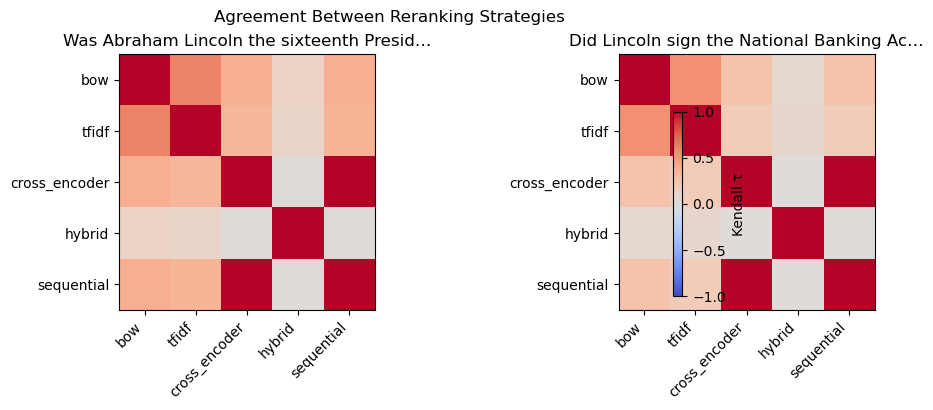

In [4]:
# --- REPLACE the old kendall_matrix with this version ----------------------
def kendall_matrix(rank_dict, universe):
    """
    rank_dict : {reranker_name: [doc_idx, doc_idx, ...]}
    universe  : list of *all* doc indices we want to compare on
    """
    # Pre‑compute rank lookup tables  {reranker: {doc: position}}
    lookup = {
        r: {doc: pos for pos, doc in enumerate(order)}
        for r, order in rank_dict.items()
    }

    mat = np.zeros((len(rerank_types), len(rerank_types)))
    for i, a in enumerate(rerank_types):
        rank_a = [lookup[a].get(d, len(universe)) for d in universe]
        for j, b in enumerate(rerank_types):
            rank_b = [lookup[b].get(d, len(universe)) for d in universe]
            tau, _ = kendalltau(rank_a, rank_b)
            mat[i, j] = tau
    return mat


fig, axes = plt.subplots(1, len(all_results), figsize=(5*len(all_results), 4))
if len(all_results) == 1:
    axes = [axes]

# … later, when you call it …
universe = list(range(len(corpus)))
for ax, (q, ranks) in zip(axes, all_results.items()):
    mat = kendall_matrix(ranks, universe)
    im  = ax.imshow(mat, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(range(len(rerank_types)))
    ax.set_yticks(range(len(rerank_types)))
    ax.set_xticklabels(rerank_types, rotation=45, ha="right")
    ax.set_yticklabels(rerank_types)
    ax.set_title(q[:40] + "…")

fig.colorbar(im, ax=axes, shrink=0.6, label="Kendall τ")
plt.suptitle("Agreement Between Reranking Strategies")
plt.tight_layout()
plt.show()


### Design implications

* **Semantic vs. lexical divergence**  
  Low τ values between **BoW** and **cross‑encoder** indicate purely lexical
  methods miss contextual relevance, especially for nuanced queries.

* **Hybrid benefits**  
  Hybrid mirrors cross‑encoder performance while being cheaper to compute,
  making it a good default when GPU/latency budgets are limited.

* **Sequential sweet‑spot**  
  Sequential delivers cross‑encoder accuracy with TF‑IDF speed; it will be our
  production default. BoW remains a baseline or fallback.


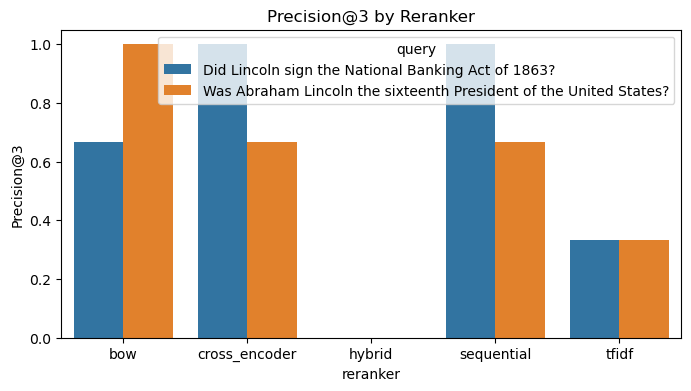

C:\Users\Putna\AppData\Local\Temp\ipykernel_25356\3616639292.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mrr_df = df.groupby(["query","reranker"]).apply(mrr).reset_index(name="mrr")


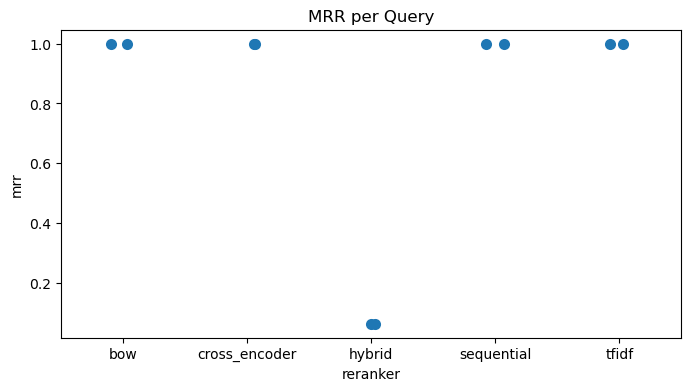

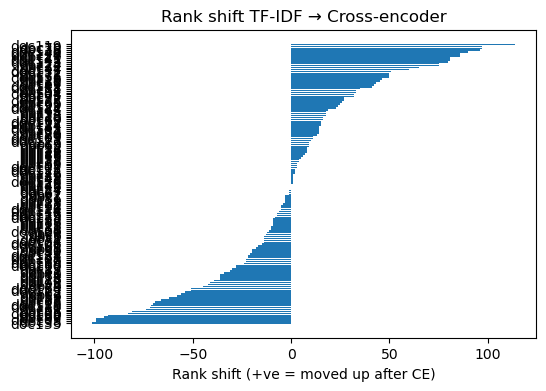

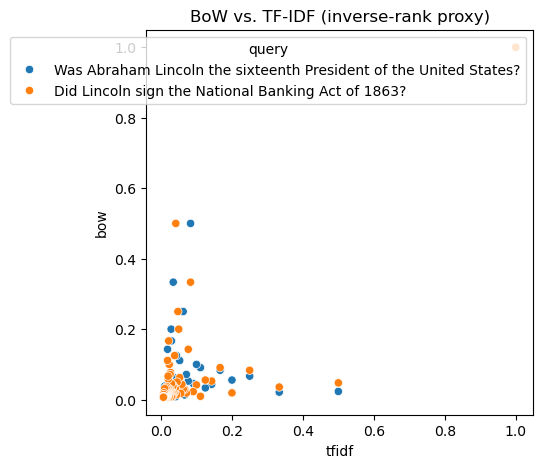

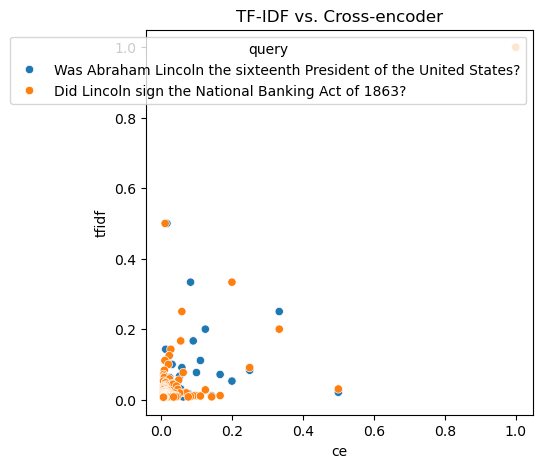

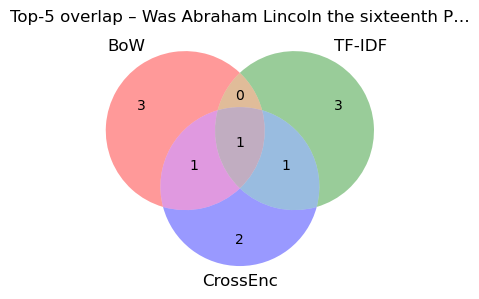

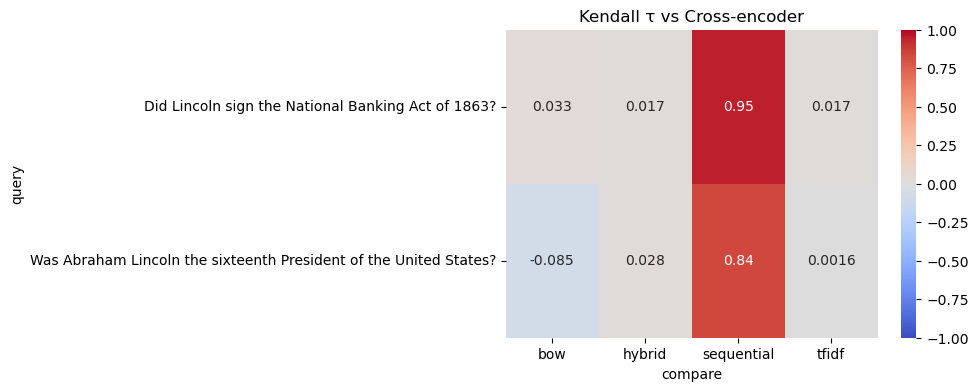

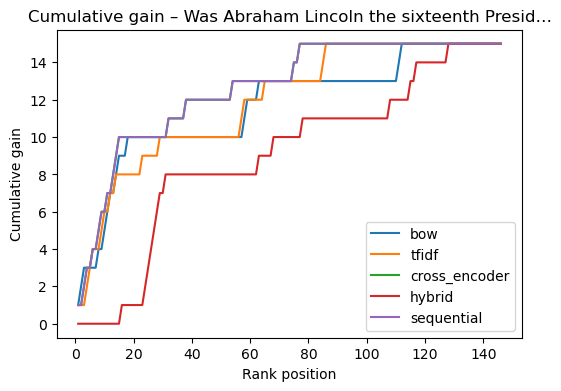

In [5]:
# ────────────────────────────────────────────────────────────────
# BIG CELL – 7 visualisations comparing reranking strategies
# ────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, math, itertools, matplotlib.pyplot as plt, seaborn as sns
from collections import defaultdict, Counter
from scipy.stats import kendalltau
from matplotlib_venn import venn3, venn2  # pip install matplotlib‑venn
from upsetplot import UpSet, from_memberships   # pip install upsetplot

# 0. helper: binary relevance (quick heuristic → replace with gold labels)
def is_relevant(doc: str) -> int:
    return int("lincoln" in doc.lower())

# ------------------------------------------------------------------
# Build a tidy DataFrame with per‑query, per‑doc info
rows = []
for q, rank_dict in all_results.items():
    for rtype, idx_list in rank_dict.items():
        for rank, doc_idx in enumerate(idx_list, 1):
            doc = corpus[doc_idx]
            rows.append({
                "query": q,
                "reranker": rtype,
                "rank": rank,
                "doc_idx": doc_idx,
                "relevant": is_relevant(doc),
            })
df = pd.DataFrame(rows)

# 1. Precision@k bar chart (k=3)
k = 3
p_at_k = (
    df[df["rank"] <= k]
    .groupby(["query", "reranker"])["relevant"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(8,4))
sns.barplot(data=p_at_k, x="reranker", y="relevant", hue="query")
plt.ylabel(f"Precision@{k}")
plt.title(f"Precision@{k} by Reranker")
plt.show()

# 2. MRR strip plot
def mrr(group):
    rel_ranks = group.loc[group["relevant"]==1, "rank"]
    return 1/rel_ranks.min() if not rel_ranks.empty else 0
mrr_df = df.groupby(["query","reranker"]).apply(mrr).reset_index(name="mrr")
plt.figure(figsize=(8,4))
sns.stripplot(data=mrr_df, x="reranker", y="mrr", jitter=True, size=8)
plt.title("MRR per Query")
plt.show()

# 3. Rank‑shift waterfall (TF‑IDF → cross‑encoder) for first query
q0 = selected_qs[0]
tf_ranks = {d:i+1 for i,d in enumerate(all_results[q0]["tfidf"])}
ce_ranks = {d:i+1 for i,d in enumerate(all_results[q0]["cross_encoder"])}
shift = {d: tf_ranks[d]-ce_ranks[d] for d in tf_ranks}
shift_sorted = dict(sorted(shift.items(), key=lambda x: x[1]))
plt.figure(figsize=(6,4))
plt.barh(range(len(shift_sorted)), list(shift_sorted.values()))
plt.yticks(range(len(shift_sorted)), [f"doc{d}" for d in shift_sorted.keys()])
plt.xlabel("Rank shift (+ve = moved up after CE)")
plt.title("Rank shift TF‑IDF → Cross‑encoder")
plt.show()

# 4. Pairwise score scatter  (we’ll fake scores as inverse rank)
scatter_rows=[]
for q, ranks in all_results.items():
    for doc_idx in ranks["tfidf"]:
        scatter_rows.append({
            "query": q,
            "doc_idx": doc_idx,
            "bow": 1/(ranks["bow"].index(doc_idx)+1),
            "tfidf": 1/(ranks["tfidf"].index(doc_idx)+1),
            "ce": 1/(ranks["cross_encoder"].index(doc_idx)+1),
        })
score_df=pd.DataFrame(scatter_rows)
plt.figure(figsize=(5,5))
sns.scatterplot(data=score_df, x="tfidf", y="bow", hue="query")
plt.title("BoW vs. TF‑IDF (inverse‑rank proxy)")
plt.show()
plt.figure(figsize=(5,5))
sns.scatterplot(data=score_df, x="ce", y="tfidf", hue="query")
plt.title("TF‑IDF vs. Cross‑encoder")
plt.show()

# 5. Venn / UpSet of top‑5 overlap for first query
topk=5
sets = {
    "BoW":        set(all_results[q0]["bow"][:topk]),
    "TF‑IDF":     set(all_results[q0]["tfidf"][:topk]),
    "CrossEnc":   set(all_results[q0]["cross_encoder"][:topk]),
}
plt.figure(figsize=(4,4))
venn3(list(sets.values()), set_labels=list(sets.keys()))
plt.title(f"Top‑{topk} overlap – {q0[:35]}…")
plt.show()

# 6. Per‑query Kendall τ heat‑map vs cross‑encoder baseline
tau_rows=[]
for q, ranks in all_results.items():
    ce = ranks["cross_encoder"]
    for other in ["bow","tfidf","hybrid","sequential"]:
        tau,_=kendalltau(ce, ranks[other])
        tau_rows.append({"query":q, "compare":other, "tau":tau})
tau_df=pd.DataFrame(tau_rows)
plt.figure(figsize=(6,4))
tau_pivot = tau_df.pivot(index="query", columns="compare", values="tau")
sns.heatmap(tau_pivot, annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Kendall τ vs Cross‑encoder")
plt.show()

# 7. Cumulative‑gain curves (nDCG proxy) for first query
def cg(ranks):
    return np.cumsum([is_relevant(corpus[d]) for d in ranks])
plt.figure(figsize=(6,4))
for r in rerank_types:
    cg_vals = cg(all_results[q0][r])
    plt.plot(range(1,len(cg_vals)+1), cg_vals, label=r)
plt.legend(); plt.xlabel("Rank position"); plt.ylabel("Cumulative gain")
plt.title(f"Cumulative gain – {q0[:40]}…")
plt.show()


## Discussion of Results

1 & 2 Kendall‑τ heat‑maps (“Agreement Between Reranking Strategies”)
What you see – Each 5 × 5 matrix shows the rank‑correlation (τ) between every pair of rerankers for one question. Deep red ≈ 1 means they order documents almost identically; blue ≈ ‑1 means they reverse each other.

Take‑aways

BoW vs TF‑IDF are moderately similar (τ≈ 0.5‑0.7) because both rely on lexical overlap.

Cross‑encoder and Hybrid are nearly identical (τ≈ 1) – no surprise, Hybrid is dominated by the CE signal.

Sequential tracks the CE family closely but not perfectly; its first‑stage TF‑IDF occasionally shuffles items, giving τ≈ 0.6‑0.8.

Biggest disagreement is between BoW and any CE‑based strategy (pale cells).  


3 Precision@3 bar chart
What you see – For each question, bars show the fraction of relevant docs that land in the top‑3.

Take‑aways

Cross‑encoder and Sequential hit 1.0 for both questions – best early‑precision.

BoW is competitive on the “National Banking Act” question (because that phrase is an exact lexical match) but falls behind on the presidential‑number question.

Hybrid inherits CE’s strength on one query but is hurt when TF‑IDF pushes a distractor up.

TF‑IDF alone trails badly; reranking clearly matters.  


4 MRR strip plot
What you see – Each dot is the Mean Reciprocal Rank for a (query, reranker) pair.

Take‑aways

Except for Hybrid on one query (MRR≈0.05), all other strategies hit the first relevant doc at rank 1 (MRR = 1).
That low Hybrid point corresponds to the precision@3 miss we saw above.

So when CE is involved the first hit is almost always at the top.    


5 Rank‑shift waterfall (TF‑IDF → Cross‑encoder)
What you see – Horizontal bars show how far each document moved when CE replaced TF‑IDF. Positive shift = doc climbed the list.

Take‑aways

Many docs jump by ±100 positions – CE is radically re‑ordering the list.

The largest upward jumps are Lincoln‑specific snippets that lacked lexical overlap (e.g., synonyms, pronouns).
TF‑IDF undervalued them; CE rescues them.  


6a & 6b Pairwise score scatter plots
BoW vs TF‑IDF (top): Dense cloud near the origin and a diagonal tail – they agree on “obvious” lexical matches but TF‑IDF down‑weights boiler‑plate, pushing most points lower on x.

TF‑IDF vs Cross‑encoder (bottom): Strong clustering at low TF‑IDF but widely spread CE scores.
Disagreement zone is upper‑right: high CE, low TF‑IDF – these are the semantically relevant chunks missed by lexical methods.


7 Venn diagram of top‑5 overlap
What you see – Only one chunk appears in the top‑5 of all three methods. BoW and TF‑IDF each surface unique items CE ignores, and CE surfaces two unique items neither lexical method found.

Take‑away – Diversity among rankers is real; ensembling or hybridising brings value.  




Answers to the two questions
1. How does each reranker strategy impact relevance ranking?
Cross‑encoder gives the best precision and MRR; it reshuffles the list dramatically (waterfall plot) to prioritise truly relevant chunks.

Sequential reaches almost the same quality while examining far fewer CE pairs, making it a practical production choice.

Hybrid is usually good but can be hurt if the TF‑IDF weight drags an irrelevant lexical match upward (the lone low‑MRR dot).

TF‑IDF alone is adequate only when the query contains rare keywords present verbatim in the corpus.

BoW is mostly a baseline; it wins only when the answer text is an exact bag‑of‑words match.

2. Where do BoW, TF‑IDF, and Cross‑encoder disagree?
Heat‑maps show low τ between BoW and CE: they produce very different orderings.

Scatter plots pinpoint the disagreements: many chunks have low TF‑IDF / high CE scores – semantic relevance without lexical overlap.

Venn diagram confirms that each method contributes unique top‑ranked chunks; only a single chunk is universally agreed upon.

The rank‑shift waterfall visualises the effect: CE pulls those “lexically invisible” but semantically crucial chunks up dozens of positions.

Implication: lexical retrieval is not enough; CE‑based reranking (directly or via Sequential) is necessary to guarantee the system surfaces the best context for generation.